In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# import sample data.
with h5py.File("sample.mat","r") as f:
    spike_train = f.get("WBC15a")['times'].value[0]
    spike_marker = f.get("DIG01")['times'].value[0]
    
spike_marker_csv = pd.read_csv("sample.csv")

# Encoding Neural Activities

## Contents

- [Properties of Neurons](#Properties-of-Neurons)
- [Spike Trains and Firing Rates](#Spike-Trains-and-Firing-Rates)
- [Measuring Firing Rate](#Measuring-Firing-Rate)
- [Tuning Curve](#Tuning-Curve)

## Properties of Neurons

- axons, soma and dendrites
- ion channels
    - sodium (Na+), potassium (K+), calcium (Ca2+), and chloride (Cl−)
- membrane potential
    - hyperpolarization
    - depolarization
- action potential
- refractory period
- synapse
    - an influx of Ca2+ that leads to the release of a neurotransmitter

## Spike Trains and Firing Rates

### neural response function
see more on [Dirac Function](#Dirac-Function).
$$\rho (t) = \sum_{i=1}^n \delta (t - t_i),\ 0 \le t_i \le T$$

### spike-count rate, r
can be determined from a single trial.
$$r = \frac{n}{T} = \frac{1}{T} \int_0^T \rho (\tau) d\tau$$

### firing rate, r(t)
average from multiple trials (or infinite tirals).
$$ r (t) = \frac{1}{\Delta t} \int_t^{t+\Delta t} \langle \rho (\tau) \rangle d\rho$$

### spiking probability
$$ r (t) \cdot \Delta t$$

### average firing rate
$$ \langle r \rangle = \frac{\langle n \rangle}{T} = \frac{1}{T} \int_0^T \langle \rho (\tau) \rangle d\tau = \frac{1}{T} \int _0^T r(\tau) d\tau $$

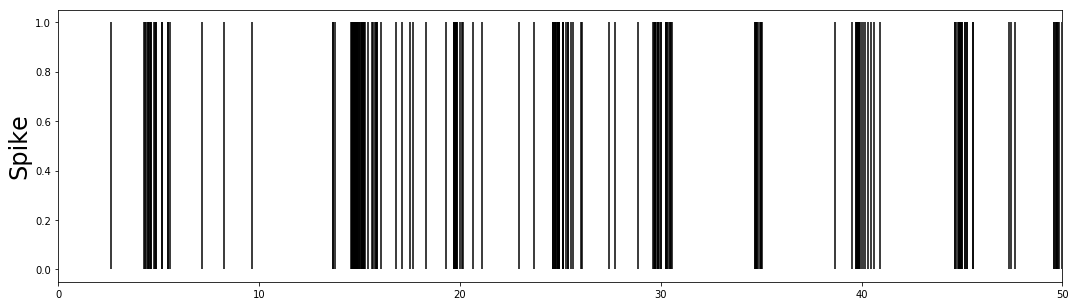

In [5]:
# a spike train of a neuron in SC.
plt.figure(figsize=(18,5))
plt.vlines(spike_train, 0, 1)
plt.xlim((0,50))
plt.ylabel("Spike", fontsize=24)
plt.show()

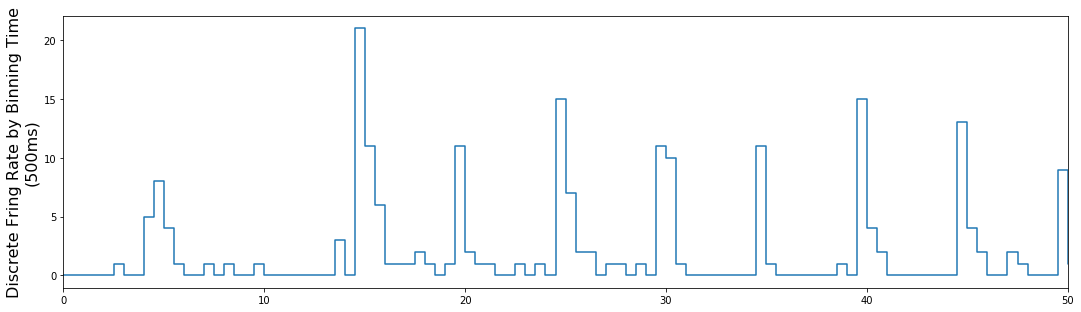

In [4]:
Y_, X_ = np.histogram(spike_train, range=(0,360), bins=720) # 500ms

X = []
Y = []

for idx in range(np.size(X_)-1):
    X.append(X_[idx])
    X.append(X_[idx+1])
    Y.append(Y_[idx])
    Y.append(Y_[idx])
    
plt.figure(figsize=(18,5))
plt.plot(X, Y)
plt.xlim((0,50))
plt.ylabel("Discrete Fring Rate by Binning Time\n(500ms)", fontsize=16)
plt.show()

## Measuring Firing Rate

### Linear Filter
$$ r_{\mathrm{approx}} (t) = \sum_{i=1}^N w(t-t_i) = \int w(\tau) \rho(t-\tau) d\tau $$
w(t) as the kernel function

### Discrete Kernel
$$ w(\tau) = \begin{cases}
    \frac{1}{\Delta t} &,\ -\frac{\Delta t}{2} \leq t \leq \frac{\Delta t}{2} \\
    0 &,\ otherwise
\end{cases}$$

### Guassian Kernel
$$ w(\tau) = \frac{1}{\sqrt{2 \pi} \sigma_w} \exp(- \frac{\tau^2}{2 \sigma_w^2}) $$

### Causal Kernel
$$ w(\tau) = [\alpha^2 \tau \exp(- \alpha \tau)]_+ $$

In [25]:
a = np.array([1,2,3,4,5,6,7,8,9])
a[a>4] = 0
a

array([1, 2, 3, 4, 0, 0, 0, 0, 0])

In [26]:
def rectangular_kernel(delta):       
    return lambda t: np.ones_like(t[(t>=-delta/2)&(t<=delta/2)]) / delta

def gaussian_kernel(sigma):
    return lambda t: 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-t**2/(2*sigma**2))

def causal_kernel(alpha):
    def causal(t):
        v = alpha**2 * t * np.exp(-alpha*t)
        v[v<0] = 0
        return v
    return causal

def get_linear_filter(train, kernel):
    return lambda t: np.sum(kernel(train - t))



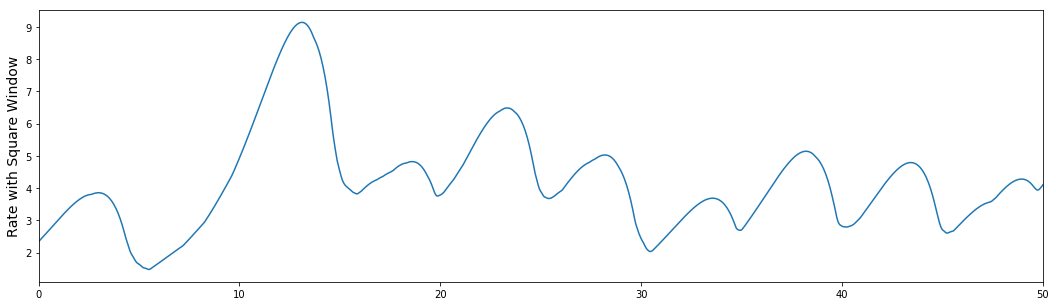

In [27]:
X = np.linspace(0,50,1000)

Y = list(map(get_linear_filter(spike_train, causal_kernel(0.5)), X))
plt.figure(figsize=(18,5))
plt.plot(X, Y)
plt.xlim((0,50))
plt.ylabel("Rate with Square Window", fontsize=14)
plt.show()

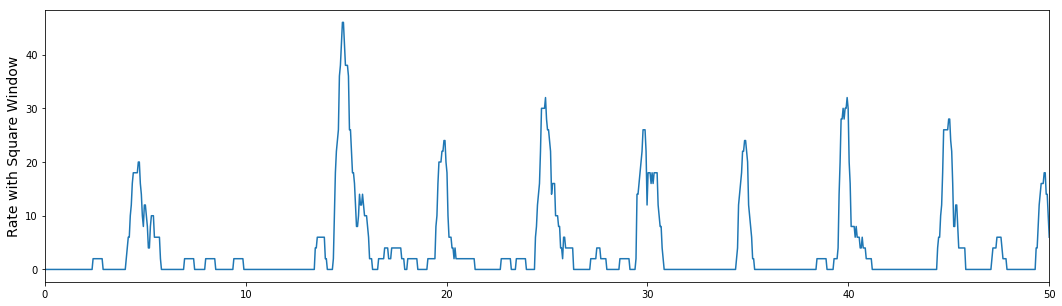

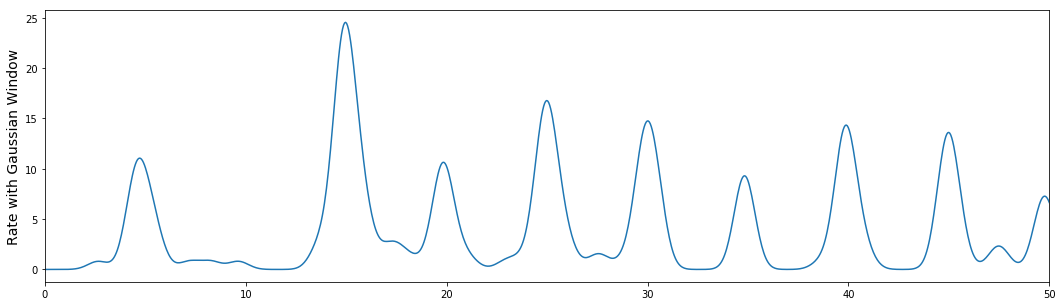

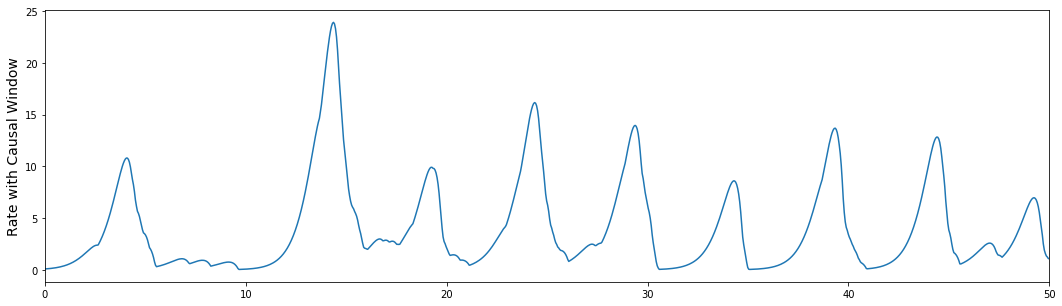

In [6]:
X = np.linspace(0,50,1000)

Y = list(map(get_linear_filter(spike_train, rectangular_kernel(0.5)), X))
plt.figure(figsize=(18,5))
plt.plot(X, Y)
plt.xlim((0,50))
plt.ylabel("Rate with Square Window", fontsize=14)
plt.show()

Y = list(map(get_linear_filter(spike_train, gaussian_kernel(0.5)), X))
plt.figure(figsize=(18,5))
plt.plot(X, Y)
plt.xlim((0,50))
plt.ylabel("Rate with Gaussian Window", fontsize=14)
plt.show()

Y = list(map(get_linear_filter(spike_train, causal_kernel(2)), X))
plt.figure(figsize=(18,5))
plt.plot(X, Y)
plt.xlim((0,50))
plt.ylabel("Rate with Causal Window", fontsize=14)
plt.show()

## Tuning Curve

### Stimulus, s
$$\langle r \rangle = f (s)$$
a.k.a. neural response tuning curve

### Gaussian tuning curve
$$ f(s) = r_{\mathrm{max}} \exp (- \frac{1}{2} (\frac{S - S_{\mathrm{max}}}{\sigma f})^2 ) $$

### Cosine tuning curve
$$ f(s) = r_0 + (r_{\mathrm{max} - r_0} \cos (S - S_{\mathrm{max}}) $$

### Sigmoid tuning curve
$$ f(s) = \frac{r_{\mathrm{max}}}{1 + \exp (\frac{S_{\frac{1}{2}} - S}{\Delta S})} $$

### Spike-Count Variability
noise models, with additive noise (i.e. independent to f(s)), or multiplicative noise.